In [1]:
###Import the modules###

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
import metpy.calc as mpcalc
from metpy.units import units
from numpy import *
import xarray as xr
from netCDF4 import Dataset, num2date
import math
import pygrib
import cdsapi
from datetime import datetime, timedelta

print("Done importing modules")

Done importing modules


In [2]:
############# Declare time, level, and lat/lon boundaries here ##########
startdate = '12/22/22 00:00'    ## must be in this format 'MM/DD/YY HH:MM'
latN = 80
latS = 10
lonW = -112    # must be in degrees E (The western hemisphere is captured between 180 and 360 degrees east)
lonE = -99
date = datetime.strptime(startdate,'%m/%d/%y %H:%M')

level = 700    # level for laplacian of temperature advection calculation
level2 = 500    # top level for differential vorticity advection calculation
level1 = 900    # bottom level for differential vorticity advection calculation

In [3]:
###Now import the composited vars for All, LP, and HP###

t500_All_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/t500_All_l0.nc')
t500_LP_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/t500_LP_l0.nc')
t500_HP_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/t500_HP_l0.nc')

z500_All_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/z500_All_l0.nc')
z500_LP_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/z500_LP_l0.nc')
z500_HP_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/z500_HP_l0.nc')

z500_All_df

<xarray.Dataset>
Dimensions:                        (latitude: 41, longitude: 53)
Coordinates:
  * latitude                       (latitude) float64 44.0 43.75 ... 34.25 34.0
  * longitude                      (longitude) float64 -112.0 -111.8 ... -99.0
Data variables:
    __xarray_dataarray_variable__  (latitude, longitude) float64 ...

In [4]:
###Gather variables and lat/lon info###

lats = t500_All_df.latitude.metpy.sel(latitude=slice(latN,latS))
lons = t500_All_df.longitude.metpy.sel(longitude=slice(lonW,lonE))
lons_2D, lats_2D = meshgrid(lons,lats)

geop = z500_All_df['__xarray_dataarray_variable__'].metpy.sel(latitude=slice(latN,latS),longitude=slice(lonW,lonE))
hght = geop/9.81 * units.meters

#tmpk = ds.t.metpy.sel(valid_time=date,pressure_level=level,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
tmpk = t500_All_df['__xarray_dataarray_variable__'].metpy.sel(latitude=slice(latN,latS),longitude=slice(lonW,lonE))
tmpk = tmpk.assign_attrs(units="kelvin")

dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

In [5]:
###Set constant values that will be needed in computations###

#Set f-plane at typical synoptic f0 value#
f0 = 1e-4 * (1 / units.second)

#Use dry gas constant from MetPy constants#
Rd = 287.06 * (units.meter * units.meter) / (units.second * units.second * units.kelvin)

In [6]:
###Apply Smoothing###

tmpk = mpcalc.smooth_gaussian(tmpk,25)
hght = mpcalc.smooth_gaussian(hght,25)

In [7]:
###Calculate the geostrophic winds###

geo = mpcalc.geostrophic_wind(hght,dx=dx,dy=dy,latitude=lats_2D*units.degrees)   
ug = geo[0]
vg = geo[1]

In [8]:
###Calculate Q-vectors###

#Compute the Q-vector components#
uqv, vqv = mpcalc.q_vector(ug, vg, tmpk, 700*100*units.Pa, dx=dx, dy=dy, static_stability=1, x_dim=-1, y_dim=-2)

#Compute the divergence of the Q-vectors calculated above#
q_div = -2.0*mpcalc.divergence(uqv, vqv, dx=dx, dy=dy)

q_div= mpcalc.smooth_gaussian(q_div,1)

In [9]:
###Import the 700 hPa vertical motion files###

w700_All_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/w700_All_l0.nc')
w700_LP_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/w700_LP_l0.nc')
w700_HP_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/w700_HP_l0.nc')
w700_HP_df['__xarray_dataarray_variable__']

<xarray.DataArray '__xarray_dataarray_variable__' (latitude: 33, longitude: 41)>
[1353 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float64 43.0 42.75 42.5 42.25 ... 35.5 35.25 35.0
  * longitude  (longitude) float64 -110.0 -109.8 -109.5 ... -100.5 -100.2 -100.0

In [10]:
###Slice the data to the appropriate domain###

#Slice a smaller domain using lat and lon coordinates#
min_lat, max_lat = 43, 35
min_lon, max_lon = -110, -100

#Apply slices#
lons_CO = lons.sel(longitude=slice(min_lon, max_lon))
lats_CO = lats.sel(latitude=slice(min_lat, max_lat))
hght_CO = hght.sel(latitude=slice(min_lat, max_lat),longitude=slice(min_lon, max_lon))
tmpk_CO = tmpk.sel(latitude=slice(min_lat, max_lat),longitude=slice(min_lon, max_lon))

/tmp/ipykernel_2546755/3281846136.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cf = ax.contourf(lons, lats, q_div*10**18, clevs_qdiv, cmap=get_cmap('PuOr_r'),


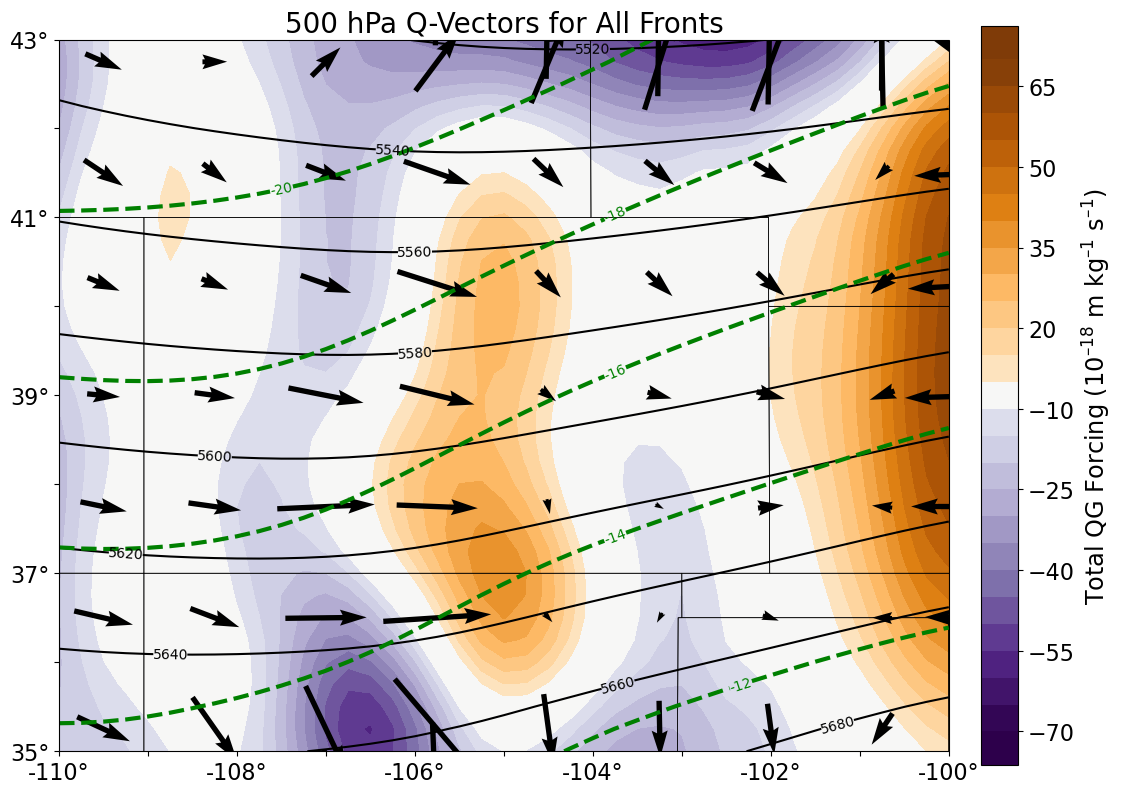

In [13]:
###Plot the q-vector data###

##### Set up the projection that will be used ##########
mapcrs = ccrs.LambertConformal(central_longitude=-55, central_latitude=45,
                               standard_parallels=(33, 45))
mapcrs = ccrs.PlateCarree()

#Set up the projection of the data; if lat/lon then PlateCarree is what you want#
datacrs = ccrs.PlateCarree()

#Start the figure and create plot axes with proper projection#
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-110, -100, 35, 43],ccrs.PlateCarree())   ## Can change the lat/lon bounds [West,East,South,North]
clev_hght = arange(0, 7000, 20)
clev_tmpc = arange(-42, 42, 2)
clevs_qdiv = list(range(-70, -9, 5))+list(range(10, 71, 5))

#Add geopolitical boundaries for map reference#
ax.add_feature(cfeature.LAND, facecolor="#bdbdbd")
countries = NaturalEarthFeature(category="cultural", scale="110m", facecolor="none", name="admin_0_boundary_lines_land")
ax.add_feature(countries, linewidth=0.5, edgecolor="black")
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
ax.coastlines('50m', linewidth=0.8)

#Height contours###
cs = ax.contour(lons_CO, lats_CO, hght_CO, clev_hght, colors='k',
                linewidths=1.5, linestyles='solid', transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i',
           rightside_up=True, use_clabeltext=True)

#Temperature contours###
cs2 = ax.contour(lons_CO, lats_CO, tmpk_CO.values-270, clev_tmpc, colors='green',
                linewidths=3.0, transform=datacrs)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d',
           rightside_up=True, use_clabeltext=True)

#Q vector con/div#
cf = ax.contourf(lons, lats, q_div*10**18, clevs_qdiv, cmap=get_cmap('PuOr_r'),
                 extend='both', transform=datacrs)
cb = plt.colorbar(cf, orientation='vertical', pad=0.03, extendrect=True, aspect=20, shrink=0.8)
cb.set_label('Total QG Forcing (10$^{–18}$ m kg$^{–1}$ s$^{–1}$)', size='xx-large')
cb.ax.tick_params(labelsize=16)

#850-hPa Q-vectors, scaled#
uqvbrb = uqv.values 
vqvbrb = vqv.values 
wind_slice = (slice(None, None, 5), slice(None, None, 5))

ax.quiver(lons[wind_slice[0]], lats[wind_slice[1]],
          uqvbrb[wind_slice],
          vqvbrb[wind_slice],
          pivot='mid', color='black',
          scale=0.15e-11, scale_units='inches',
          width=0.006,
          transform=datacrs)

#Titles and labels#
plt.title('500 hPa Q-Vectors for All Fronts', fontsize=20)
#plt.title('Valid:'+startdate, loc='right', fontsize=16)

#Fix the lats and lon values#
ax.set_xticks(range(-110, -99, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())
x_ticks = [-110,-108,-106,-104,-102,-100]
x_tick_labels = ['-110°','-108°','-106°','-104°','-102°','-100°']
y_ticks = [35,37,39,41,43]
y_tick_labels = ['35°','37°','39°','41°','43°']
plt.xticks(x_ticks, x_tick_labels)
plt.yticks(y_ticks, y_tick_labels)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks(range(-110, -99, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())
#ax.set_xlabel('Longitude', fontsize=14)
#ax.set_ylabel('Latitude', fontsize=14)

#plt.savefig("QVectors_All_500.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()

In [ ]:
###Plot the vertical motion###

##### Set up the projection that will be used ##########
mapcrs = ccrs.LambertConformal(central_longitude=-55, central_latitude=45,
                               standard_parallels=(33, 45))
mapcrs = ccrs.PlateCarree()

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-110, -100, 35, 43],ccrs.PlateCarree())   ## Can change the lat/lon bounds [West,East,South,North]
clev_omega = arange(-1.5, 1.6, 0.1)

#Add geopolitical boundaries for map reference#
ax.add_feature(cfeature.LAND, facecolor="#bdbdbd")
countries = NaturalEarthFeature(category="cultural", scale="110m", facecolor="none", name="admin_0_boundary_lines_land")
ax.add_feature(countries, linewidth=0.5, edgecolor="black")
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
ax.coastlines('50m', linewidth=0.8)

#Vertical motions#
cf = ax.contourf(lons_CO, lats_CO, w700_All_df['__xarray_dataarray_variable__'], clev_omega, cmap=get_cmap('PuOr_r'),
                 extend='both', transform=datacrs)
cb = plt.colorbar(cf, orientation='vertical', pad=0.03, extendrect=True, aspect=20, shrink=0.8)
cb.set_label('700 hPa Omega (Pa s$^{–1}$)', size='xx-large')
cb.ax.tick_params(labelsize=16)

#Titles and labels#
plt.title('Vertical motion for All Fronts', fontsize=20)
#plt.title('Valid:'+startdate, loc='right', fontsize=16)

#Fix the lats and lon values#
ax.set_xticks(range(-110, -99, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())
x_ticks = [-110,-108,-106,-104,-102,-100]
x_tick_labels = ['-110°','-108°','-106°','-104°','-102°','-100°']
y_ticks = [35,37,39,41,43]
y_tick_labels = ['35°','37°','39°','41°','43°']
plt.xticks(x_ticks, x_tick_labels)
plt.yticks(y_ticks, y_tick_labels)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks(range(-110, -99, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())
#ax.set_xlabel('Longitude', fontsize=14)
#ax.set_ylabel('Latitude', fontsize=14)

#plt.savefig("700hPa_omega_All.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()